# Linear elasticity

## Review of the formulation

Linear elastic bodies are caracterized by a quadratic strain energy density function 

$$w(\varepsilon)=\frac{1}{2} \mathbb{C} \,(\varepsilon-\varepsilon_0)\cdot (\varepsilon-\varepsilon_0)$$
where

-  $\varepsilon$ is the second order (symmetric) strain tensor
- $\varepsilon_0$ is the inelastic strain (e.g. for thermal strain in isotropic materials $\varepsilon_0=-\alpha \Delta T$
- $\mathbb{C}$ is the forth order elastic tensor.

The (symmetric) stress tensor is defined as 
$$
\sigma(\varepsilon) = \dfrac{\partial w(\varepsilon)}{\partial \varepsilon}
$$
For isotropic materials denoting by $\lambda$ and $\mu$ are the Lamé moduli.

$$
w(\varepsilon) = \frac{\lambda}{2} (\mathrm{tr}(\varepsilon-\varepsilon_0))^2+\mu \Vert\varepsilon-\varepsilon_0\Vert^2, 
\qquad 
\sigma(\varepsilon)={\lambda}\,\mathrm{tr}(\varepsilon-\varepsilon_0)+2\mu (\varepsilon-\varepsilon_0)
$$

The strain is given in therm of the displacement by $$ \varepsilon(u)=\mathrm{sym}(\nabla u)=\dfrac{\nabla u+\nabla u^T}{2}$$
Note that here $u,v$ are vector fields in $\mathcal R^2$ or $\mathcal R^3$.

Considering a body $\Omega$ submitted to body forces $b$ surface, traction $f$ on $\partial_f \Omega$, applied displacements $\bar u$ on $\partial_u\Omega$, and inelastic strain $\varepsilon_0$, the  weak formulation is: 

Find a *trial function* $u\in V$, $u=\bar u$ on $\partial_u\Omega$, such that for each *test function* in $v\in V$, $v=0$ on $\partial_u\Omega$: 

$$
a(u,v) = l(v)
$$
where 
$$a(u,v)=\int_\Omega \sigma(\varepsilon(u))\cdot \varepsilon(v)\,\mathrm{d}x, \quad \ell(v)=\int_\Omega b\cdot v\, \mathrm{d}x+\int_{\partial_f \Omega} f\cdot v$$

**Exercices:**

1. Show that the weak formulation above coincides with the stationarity condition of the following minimization problem for the potential energy $\mathcal E(u)$
$$
\min_{u\in V, \, u=\bar u \text{ on } \partial_u\Omega}\mathcal E(u),\qquad \mathcal E(u)=\dfrac{1}{2}a(u,u) - l(v)
$$
2. Show that the weak formulation above is equivalent to the classical equation of linear elasticity in the strong form with the associated Dirichlet et Neumann boundary conditions
3. Show by dimensional analysis that, without loss of generality, one can set, up to a rescaling of the variables, $L:=\vert\Omega\vert=1$ and $\lambda=1$ when performing numerical computations

## Finite element solution (with FEniCS)

We will solve now the classical problem of the traction of plate with an hole (in plane-strain)

From now on I will import fenics in the main namespace

In [1]:
from fenics import *
import numpy as np
import mshr
import matplotlib.pyplot as plt
%matplotlib inline

I use [mshr](https://bitbucket.org/fenics-project/mshr) to make a mesh with an hole using. A good alternative is [gmsh](http://gmsh.info): you can do your mesh, save to file, convert to fenics format using [meshio](https://github.com/nschloe/meshio) and load in fenics from file.

### Mesh 

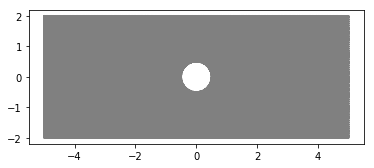

In [14]:
xmin, xmax = -5., 5.
ymin, ymax = -2., 2.
radius = 0.5
square = mshr.Rectangle(Point(xmin, ymin),Point(xmax, ymax))
hole = mshr.Circle(Point(0.,0.),radius)
geom = square - hole
mesh = mshr.generate_mesh(geom,150)
plot(mesh)

### Boundary indicators (for bcs)

In [15]:
class Left(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return near(x[0], xmin, tol) and on_boundary
    
class Right(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return near(x[0], xmax, tol) and on_boundary
    
class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return near(x[1], ymin, tol) and on_boundary
    
class Top(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return near(x[1], ymin, tol) and on_boundary
    
left = Left()
right = Right()
bottom = Bottom()
top = Top()


### Function space

In [16]:
element = VectorElement("P", triangle, degree = 1)
# Create function space
V = FunctionSpace(mesh, element)
# Create test and trial functions, and source term
u = TrialFunction(V)
v = TestFunction(V)

### BCs 

In [17]:
bc_left = DirichletBC(V, (0.,0.), left)
bc_right = DirichletBC(V.sub(0), 1., right)
bcs = [bc_left,bc_right]

###  Variational formulation

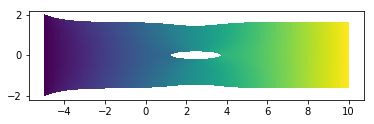

In [18]:
# Bulk load 
b = Constant((0.,0.))
# Elasticity parameters
E, nu = Constant(10), Constant(0.3)
mu, lmbda = E/(2*(1.0 + nu)), E*nu/((1.0 + nu)*(1.0 -2.0*nu))

ndim = u.geometric_dimension()

def eps(u):
    return sym(grad(u))

def sigma(epsilon):
    return  2*mu*epsilon + lmbda*tr(epsilon)*Identity(ndim)

# Weak formulation
a = inner(sigma(eps(u)), eps(v))*dx 
L = inner(b,v)*dx

# Set up PDE and solve
us = Function(V)
problem = LinearVariationalProblem(a, L, us, bcs)
solver = LinearVariationalSolver(problem)
solver.solve()
plot(5*us, mode = "displacement")

### Postprocessing: stress calculation

Define Von Mises Stress

In [19]:
sigma_sol = sigma(eps(us))
s = sigma_sol - (1./ndim)*tr(sigma_sol)*Identity(ndim)

Project it on a FE function space

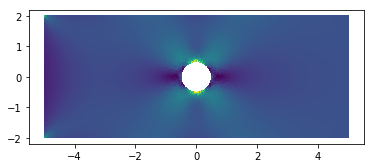

In [20]:
stress_element = FiniteElement('DG', triangle, 0)
S = FunctionSpace(mesh, stress_element)
von_Mises = sqrt(ndim*inner(s, s))
von_Mises_p = project(von_Mises, S)
plot(von_Mises_p)

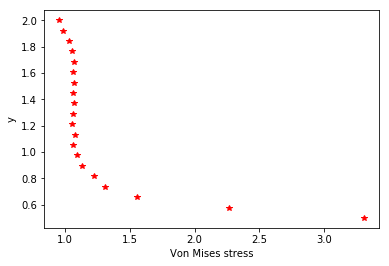

In [21]:
ypoints = np.linspace(radius, ymax, 20)
points = [[.0,y] for y in ypoints]
values = [von_Mises_p(point) for point in points]
plt.plot(values, ypoints, '*r')
plt.ylabel("y")
plt.xlabel("Von Mises stress")

In [ ]:
uref, sref = elastic_solver(250,1)
plot(uref*.01,mode='displacement')